<html> <h1 style="font-style:bold; color:blue;"> Machine Learning in Finance </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-7 </h1> </html>

## LSTM (Long Short-Term Memory)

## GOLD-2022 dataset 
     
### Predictions of The Highest & Lowest prices DURING five(5) following minutes
- Early-Stopping
- Loss function: MSE

### length of analysed history (sliding window)- 50 minutes ago

#### dataset for training: 30.000 rows (minutes) ~ 1 month
#### train / test = 90 /10

___________________________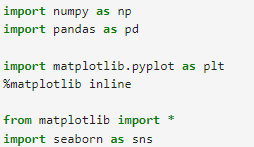

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
# Corrected: Removed the extra '¥' character. This is for Jupyter/IPython notebooks.
import seaborn as sns
# Removed: 'from matplotlib import *' as it's often unnecessary and can cause naming conflicts.

_____________________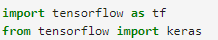

In [2]:
import tensorflow as tf
from tensorflow import keras

2025-11-04 14:02:37.241963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


__________________

In [3]:
print(tf.__version__)

2.15.0


_____________________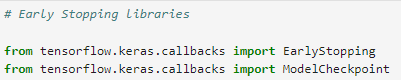

In [4]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint

___________________

In [5]:
np.random.seed(19)

<html> <h2 style=" color:blue;"> Data </h2> </html>

In [9]:
# We use a slightly different normalisation principle for prices.
# We use the same principle as in the practical session in Week-6 for Volumes and Deltas.

# We use another principlefor prices:
# For normalisation, it is not necessary for the normalised columns' values to be in the range between [0,1].
# What is more important is that all the values in these columns are approximately the same order of magnitude, 
# i.e. do not differ by hundreds or more times.
# Therefore we can simply divide the gold prices by 1000

_____________________________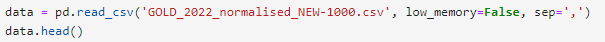

In [6]:
data = pd.read_csv('GOLD_2022_normalised_NEW-1000.csv', low_memory=False, sep=',')
data.head()

,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_day,New_week,Y_High_Bid,Y_Low_Ask
0,1.828604,1.829628,1.828544,1.829504,0.009718,1.829656,1.830936,1.829386,1.830196,0.009050,0.629054,0.000709,0.751830,0.691381,0.801417,0.836836,1,1,1.829628,1.829386
1,1.829504,1.830104,1.829398,1.830004,0.007151,1.829936,1.830676,1.829916,1.830632,0.009946,0.631369,0.002969,0.898229,0.865171,0.877922,0.851948,0,0,1.830104,1.829916
2,1.830098,1.830604,1.829998,1.830534,0.011126,1.830612,1.831226,1.830516,1.831146,0.016555,0.633130,0.005766,0.878867,0.853365,0.877922,0.855726,0,0,1.830604,1.830516
3,1.830534,1.830704,1.830504,1.830674,0.001991,1.831156,1.831306,1.831046,1.831046,0.006808,0.632720,0.005116,0.853365,0.858087,0.872255,0.912397,0,0,1.830704,1.831046
4,1.830674,1.830674,1.830448,1.830508,0.006660,1.831026,1.831181,1.830886,1.831086,0.010739,0.632227,0.004332,0.917119,0.880520,0.896812,0.863754,0,0,1.830674,1.830886


,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_day,New_week,Y_High_Bid,Y_Low_Ask
0,1.828604,1.829628,1.828544,1.829504,0.009718,1.829656,1.830936,1.829386,1.830196,0.009050,0.629054,0.000709,0.751830,0.691381,0.801417,0.836836,1,1,1.829628,1.829386
1,1.829504,1.830104,1.829398,1.830004,0.007151,1.829936,1.830676,1.829916,1.830632,0.009946,0.631369,0.002969,0.898229,0.865171,0.877922,0.851948,0,0,1.830104,1.829916
2,1.830098,1.830604,1.829998,1.830534,0.011126,1.830612,1.831226,1.830516,1.831146,0.016555,0.633130,0.005766,0.878867,0.853365,0.877922,0.855726,0,0,1.830604,1.830516
3,1.830534,1.830704,1.830504,1.830674,0.001991,1.831156,1.831306,1.831046,1.831046,0.006808,0.632720,0.005116,0.853365,0.858087,0.872255,0.912397,0,0,1.830704,1.831046
4,1.830674,1.830674,1.830448,1.830508,0.006660,1.831026,1.831181,1.830886,1.831086,0.010739,0.632227,0.004332,0.917119,0.880520,0.896812,0.863754,0,0,1.830674,1.830886


_____________________________

In [7]:
data.tail()

,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_day,New_week,Y_High_Bid,Y_Low_Ask
354689,1.824248,1.824348,1.824148,1.824248,0.001962,1.824852,1.825052,1.824752,1.824852,0.001409,0.629130,0.000588,0.857615,0.834002,0.857615,0.857615,0,0,1.824348,1.824752
354690,1.824148,1.824148,1.823737,1.823948,0.002202,1.824752,1.824752,1.824552,1.824552,0.001165,0.628807,0.001101,0.857615,0.857615,0.807792,0.857615,0,0,1.824148,1.824552
354691,1.823948,1.824090,1.823347,1.823848,0.003087,1.824505,1.824675,1.824252,1.824452,0.002884,0.629365,0.000215,0.868713,0.862102,0.786541,0.857615,0,0,1.824090,1.824252
354692,1.823748,1.823748,1.823023,1.823025,0.003976,1.824452,1.824452,1.823852,1.823852,0.001494,0.627841,0.002636,0.834002,0.834002,0.804486,0.804959,0,0,1.823748,1.823852
354693,1.823448,1.823463,1.823006,1.823463,0.006583,1.823955,1.824252,1.823852,1.824252,0.000892,0.625696,0.006044,0.880520,0.813932,0.800472,0.813932,0,0,1.823463,1.823852


,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_day,New_week,Y_High_Bid,Y_Low_Ask
354689,1.824248,1.824348,1.824148,1.824248,0.001962,1.824852,1.825052,1.824752,1.824852,0.001409,0.629130,0.000588,0.857615,0.834002,0.857615,0.857615,0,0,1.824348,1.824752
354690,1.824148,1.824148,1.823737,1.823948,0.002202,1.824752,1.824752,1.824552,1.824552,0.001165,0.628807,0.001101,0.857615,0.857615,0.807792,0.857615,0,0,1.824148,1.824552
354691,1.823948,1.824090,1.823347,1.823848,0.003087,1.824505,1.824675,1.824252,1.824452,0.002884,0.629365,0.000215,0.868713,0.862102,0.786541,0.857615,0,0,1.824090,1.824252
354692,1.823748,1.823748,1.823023,1.823025,0.003976,1.824452,1.824452,1.823852,1.823852,0.001494,0.627841,0.002636,0.834002,0.834002,0.804486,0.804959,0,0,1.823748,1.823852
354693,1.823448,1.823463,1.823006,1.823463,0.006583,1.823955,1.824252,1.823852,1.824252,0.000892,0.625696,0.006044,0.880520,0.813932,0.800472,0.813932,0,0,1.823463,1.823852


___________________________

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354694 entries, 0 to 354693
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Open_Bid          354694 non-null  float64
 1   High_Bid          354694 non-null  float64
 2   Low_Bid           354694 non-null  float64
 3   Close_Bid         354694 non-null  float64
 4   Volume_Bid        354694 non-null  float64
 5   Open_Ask          354694 non-null  float64
 6   High_Ask          354694 non-null  float64
 7   Low_Ask           354694 non-null  float64
 8   Close_Ask         354694 non-null  float64
 9   Volume_Ask        354694 non-null  float64
 10  Volume_Delta      354694 non-null  float64
 11  Volume_Delta_abs  354694 non-null  float64
 12  Open_Delta        354694 non-null  float64
 13  High_Delta        354694 non-null  float64
 14  Low_Delta         354694 non-null  float64
 15  Close_Delta       354694 non-null  float64
 16  New_day           35

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354694 entries, 0 to 354693
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Open_Bid          354694 non-null  float64
 1   High_Bid          354694 non-null  float64
 2   Low_Bid           354694 non-null  float64
 3   Close_Bid         354694 non-null  float64
 4   Volume_Bid        354694 non-null  float64
 5   Open_Ask          354694 non-null  float64
 6   High_Ask          354694 non-null  float64
 7   Low_Ask           354694 non-null  float64
 8   Close_Ask         354694 non-null  float64
 9   Volume_Ask        354694 non-null  float64
 10  Volume_Delta      354694 non-null  float64
 11  Volume_Delta_abs  354694 non-null  float64
 12  Open_Delta        354694 non-null  float64
 13  High_Delta        354694 non-null  float64
 14  Low_Delta         354694 non-null  float64
 15  Close_Delta       354694 non-null  float64
 16  New_day           35

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [9]:
# memory size reduction

columns_float =['Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 
                'Open_Ask', 'High_Ask', 'Low_Ask', 'Close_Ask', 'Volume_Ask', 
                'Volume_Delta', 'Volume_Delta_abs', 
                'Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta',
                'Y_High_Bid', 'Y_Low_Ask']

columns_integer =['New_day', 'New_week']



_____________________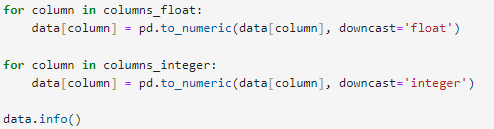

In [13]:
for column in columns_float:
    data[column] = pd.to_numeric(data[column], downcast='float')

for column in columns_integer:
    data[column] = pd.to_numeric(data[column], downcast='integer')

data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354694 entries, 0 to 354693
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Open_Bid          354694 non-null  float32
 1   High_Bid          354694 non-null  float32
 2   Low_Bid           354694 non-null  float32
 3   Close_Bid         354694 non-null  float32
 4   Volume_Bid        354694 non-null  float32
 5   Open_Ask          354694 non-null  float32
 6   High_Ask          354694 non-null  float32
 7   Low_Ask           354694 non-null  float32
 8   Close_Ask         354694 non-null  float32
 9   Volume_Ask        354694 non-null  float32
 10  Volume_Delta      354694 non-null  float32
 11  Volume_Delta_abs  354694 non-null  float32
 12  Open_Delta        354694 non-null  float32
 13  High_Delta        354694 non-null  float32
 14  Low_Delta         354694 non-null  float32
 15  Close_Delta       354694 non-null  float32
 16  New_day           35

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354694 entries, 0 to 354693
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Open_Bid          354694 non-null  float32
 1   High_Bid          354694 non-null  float32
 2   Low_Bid           354694 non-null  float32
 3   Close_Bid         354694 non-null  float32
 4   Volume_Bid        354694 non-null  float32
 5   Open_Ask          354694 non-null  float32
 6   High_Ask          354694 non-null  float32
 7   Low_Ask           354694 non-null  float32
 8   Close_Ask         354694 non-null  float32
 9   Volume_Ask        354694 non-null  float32
 10  Volume_Delta      354694 non-null  float32
 11  Volume_Delta_abs  354694 non-null  float32
 12  Open_Delta        354694 non-null  float32
 13  High_Delta        354694 non-null  float32
 14  Low_Delta         354694 non-null  float32
 15  Close_Delta       354694 non-null  float32
 16  New_day           35

_____________________________

In [14]:
data.describe()

,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_day,New_week,Y_High_Bid,Y_Low_Ask
count,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,3.546940e+05,354694.000000,354694.000000,354694.000000,354694.000000
mean,1.801307,1.801587,1.801030,1.801308,0.013636,1.801681,1.801959,1.801403,1.801681,0.013593,0.629471,0.003893,0.912002,0.912279,0.912270,9.119296e-01,0.000727,0.000147,1.801587,1.801403
std,0.091688,0.091719,0.091654,0.091687,0.012004,0.091689,0.091719,0.091655,0.091689,0.011920,0.004936,0.006651,0.018467,0.017149,0.017005,1.719723e-02,0.026960,0.012107,0.091719,0.091655
min,1.614858,1.615848,1.614710,1.614858,0.000000,1.615252,1.616172,1.615092,1.615245,0.000000,0.000000,0.000000,0.484534,0.285714,0.271547,-2.453763e-14,0.000000,0.000000,1.615848,1.615092
25%,1.734037,1.734294,1.733790,1.734034,0.005797,1.734402,1.734662,1.734153,1.734402,0.005797,0.628112,0.000783,0.902479,0.902479,0.902479,9.024794e-01,0.000000,0.000000,1.734294,1.734153
50%,1.804496,1.804728,1.804248,1.804492,0.010599,1.804842,1.805075,1.804595,1.804843,0.010555,0.629500,0.002166,0.913577,0.914286,0.914050,9.133412e-01,0.000000,0.000000,1.804728,1.804595
75%,1.855088,1.855348,1.854847,1.855086,0.017857,1.855442,1.855702,1.855202,1.855442,0.017790,0.630837,0.004939,0.923022,0.923022,0.923022,9.227863e-01,0.000000,0.000000,1.855348,1.855202
max,2.069368,2.070358,2.066518,2.069358,1.000000,2.069812,2.070778,2.067052,2.069802,0.579609,1.000000,1.000000,0.999056,1.000000,0.999764,9.990555e-01,1.000000,1.000000,2.070358,2.067052


,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_day,New_week,Y_High_Bid,Y_Low_Ask
count,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,354694.000000,3.546940e+05,354694.000000,354694.000000,354694.000000,354694.000000
mean,1.801307,1.801587,1.801030,1.801308,0.013636,1.801681,1.801959,1.801403,1.801681,0.013593,0.629471,0.003893,0.912002,0.912279,0.912270,9.119296e-01,0.000727,0.000147,1.801587,1.801403
std,0.091688,0.091719,0.091654,0.091687,0.012004,0.091689,0.091719,0.091655,0.091689,0.011920,0.004936,0.006651,0.018467,0.017149,0.017005,1.719723e-02,0.026960,0.012107,0.091719,0.091655
min,1.614858,1.615848,1.614710,1.614858,0.000000,1.615252,1.616172,1.615092,1.615245,0.000000,0.000000,0.000000,0.484534,0.285714,0.271547,-2.453763e-14,0.000000,0.000000,1.615848,1.615092
25%,1.734037,1.734294,1.733790,1.734034,0.005797,1.734402,1.734662,1.734153,1.734402,0.005797,0.628112,0.000783,0.902479,0.902479,0.902479,9.024794e-01,0.000000,0.000000,1.734294,1.734153
50%,1.804496,1.804728,1.804248,1.804492,0.010599,1.804842,1.805075,1.804595,1.804843,0.010555,0.629500,0.002166,0.913577,0.914286,0.914050,9.133412e-01,0.000000,0.000000,1.804728,1.804595
75%,1.855088,1.855348,1.854847,1.855086,0.017857,1.855442,1.855702,1.855202,1.855442,0.017790,0.630837,0.004939,0.923022,0.923022,0.923022,9.227863e-01,0.000000,0.000000,1.855348,1.855202
max,2.069368,2.070358,2.066518,2.069358,1.000000,2.069812,2.070778,2.067052,2.069802,0.579609,1.000000,1.000000,0.999056,1.000000,0.999764,9.990555e-01,1.000000,1.000000,2.070358,2.067052


_____________________________

In [15]:
data.shape

(354694, 20)

(354694, 20)

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

<Figure size 1200x500 with 0 Axes>

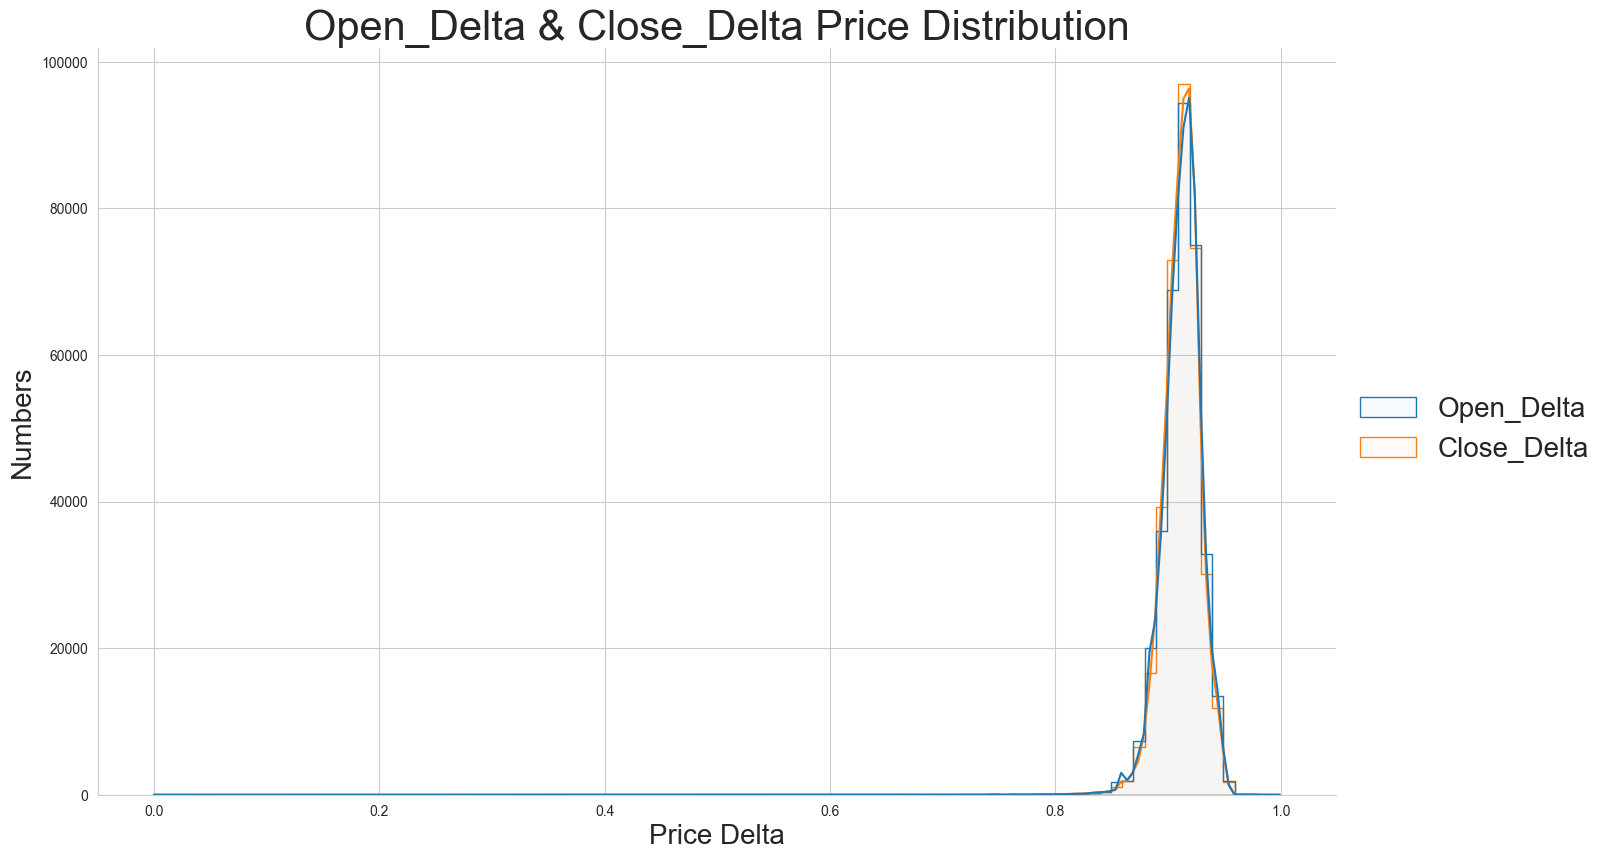

In [16]:
fig = plt.figure(figsize=(12, 5))
plt.rc('axes', titlesize= 30 ) 
sns.set_style('whitegrid')
sns.set_context(rc={'legend.fontsize': 20.0}) 

sns.displot( 
            data[['Open_Delta', 'Close_Delta']],
            height=8,
            aspect=1.7,
            kde=True,
            element="step",
            bins=100,
            alpha=0.03,          
                        
)

plt.title('Open_Delta & Close_Delta Price Distribution')
plt.xlabel('Price Delta', size= 20)
plt.ylabel('Numbers', size= 20)
plt.show()

<html> <h3 style="font-style:italic; color:blue;"> Date Transformation </h3> </html>

In [19]:
# We will predict the Highest and Lowest prices DURING the next 5 minutes. 

# To do this in the data output (vector of answers), we shift prices sequentially to 5 minutes up, 
# and find max and min prices during these 5 minutes
# Then you need to delete the 5 last rows since there are no prices for the next 5 minutes. 
# Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 5 rows up.

_________________________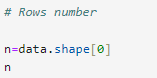

In [20]:
n=data.shape[0]
n

354694

354694

_________________________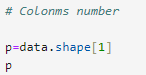

In [21]:
p=data.shape[1]
p

20

20

__________________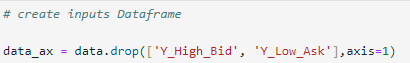

In [27]:
data_ax = data.drop(['Y_High_Bid','Y_Low_Ask'], axis=1)

In [28]:
data_ax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354694 entries, 0 to 354693
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Open_Bid          354694 non-null  float32
 1   High_Bid          354694 non-null  float32
 2   Low_Bid           354694 non-null  float32
 3   Close_Bid         354694 non-null  float32
 4   Volume_Bid        354694 non-null  float32
 5   Open_Ask          354694 non-null  float32
 6   High_Ask          354694 non-null  float32
 7   Low_Ask           354694 non-null  float32
 8   Close_Ask         354694 non-null  float32
 9   Volume_Ask        354694 non-null  float32
 10  Volume_Delta      354694 non-null  float32
 11  Volume_Delta_abs  354694 non-null  float32
 12  Open_Delta        354694 non-null  float32
 13  High_Delta        354694 non-null  float32
 14  Low_Delta         354694 non-null  float32
 15  Close_Delta       354694 non-null  float32
 16  New_day           35

________________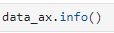

In [29]:
data_ax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354694 entries, 0 to 354693
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Open_Bid          354694 non-null  float32
 1   High_Bid          354694 non-null  float32
 2   Low_Bid           354694 non-null  float32
 3   Close_Bid         354694 non-null  float32
 4   Volume_Bid        354694 non-null  float32
 5   Open_Ask          354694 non-null  float32
 6   High_Ask          354694 non-null  float32
 7   Low_Ask           354694 non-null  float32
 8   Close_Ask         354694 non-null  float32
 9   Volume_Ask        354694 non-null  float32
 10  Volume_Delta      354694 non-null  float32
 11  Volume_Delta_abs  354694 non-null  float32
 12  Open_Delta        354694 non-null  float32
 13  High_Delta        354694 non-null  float32
 14  Low_Delta         354694 non-null  float32
 15  Close_Delta       354694 non-null  float32
 16  New_day           35

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354694 entries, 0 to 354693
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Open_Bid          354694 non-null  float32
 1   High_Bid          354694 non-null  float32
 2   Low_Bid           354694 non-null  float32
 3   Close_Bid         354694 non-null  float32
 4   Volume_Bid        354694 non-null  float32
 5   Open_Ask          354694 non-null  float32
 6   High_Ask          354694 non-null  float32
 7   Low_Ask           354694 non-null  float32
 8   Close_Ask         354694 non-null  float32
 9   Volume_Ask        354694 non-null  float32
 10  Volume_Delta      354694 non-null  float32
 11  Volume_Delta_abs  354694 non-null  float32
 12  Open_Delta        354694 non-null  float32
 13  High_Delta        354694 non-null  float32
 14  Low_Delta         354694 non-null  float32
 15  Close_Delta       354694 non-null  float32
 16  New_day           35

__________________________

In [30]:
data_ax.shape

(354694, 18)

(354694, 18)

__________________________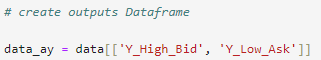

In [31]:
data_ay=data[['Y_High_Bid','Y_Low_Ask']]

________________

In [32]:
data_ay.shape

(354694, 2)

(354694, 2)

___________________

In [33]:
data_ay.head(6)

,Y_High_Bid,Y_Low_Ask
0,1.829628,1.829386
1,1.830104,1.829916
2,1.830604,1.830516
3,1.830704,1.831046
4,1.830674,1.830886
5,1.830568,1.830046


,Y_High_Bid,Y_Low_Ask
0,1.829628,1.829386
1,1.830104,1.829916
2,1.830604,1.830516
3,1.830704,1.831046
4,1.830674,1.830886
5,1.830568,1.830046


_________________________

In [34]:
data_ay.tail(10)

,Y_High_Bid,Y_Low_Ask
354684,1.824508,1.824852
354685,1.824508,1.824952
354686,1.824478,1.824852
354687,1.824448,1.824852
354688,1.824478,1.824952
354689,1.824348,1.824752
354690,1.824148,1.824552
354691,1.824090,1.824252
354692,1.823748,1.823852
354693,1.823463,1.823852


,Y_High_Bid,Y_Low_Ask
354684,1.824508,1.824852
354685,1.824508,1.824952
354686,1.824478,1.824852
354687,1.824448,1.824852
354688,1.824478,1.824952
354689,1.824348,1.824752
354690,1.824148,1.824552
354691,1.824090,1.824252
354692,1.823748,1.823852
354693,1.823463,1.823852


______________________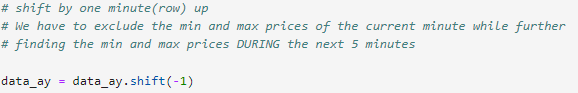

In [35]:
data_ay=data_ay.shift(-1)

____________________

In [36]:
data_ay.head(6)

,Y_High_Bid,Y_Low_Ask
0,1.830104,1.829916
1,1.830604,1.830516
2,1.830704,1.831046
3,1.830674,1.830886
4,1.830568,1.830046
5,1.830244,1.830076


,Y_High_Bid,Y_Low_Ask
0,1.830104,1.829916
1,1.830604,1.830516
2,1.830704,1.831046
3,1.830674,1.830886
4,1.830568,1.830046
5,1.830244,1.830076


____________________

In [37]:
data_ay.tail(10)

,Y_High_Bid,Y_Low_Ask
354684,1.824508,1.824952
354685,1.824478,1.824852
354686,1.824448,1.824852
354687,1.824478,1.824952
354688,1.824348,1.824752
354689,1.824148,1.824552
354690,1.824090,1.824252
354691,1.823748,1.823852
354692,1.823463,1.823852
354693,NaN,NaN


,Y_High_Bid,Y_Low_Ask
354684,1.824508,1.824952
354685,1.824478,1.824852
354686,1.824448,1.824852
354687,1.824478,1.824952
354688,1.824348,1.824752
354689,1.824148,1.824552
354690,1.824090,1.824252
354691,1.823748,1.823852
354692,1.823463,1.823852
354693,NaN,NaN


#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [38]:
# create new colomns: MIN_Lowest(Low_Ask) and MAX_Highest(High_Bid) prices of DURING NEXT 5 minutes

# Forward-looking window
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)

data_ay['Y_High_Bid_5'] = data_ay['Y_High_Bid'].rolling(window=indexer).max()
data_ay['Y_Low_Ask_5']  = data_ay['Y_Low_Ask'].rolling(window=indexer).min()

___________________

In [39]:
data_ay.head(6)

,Y_High_Bid,Y_Low_Ask,Y_High_Bid_5,Y_Low_Ask_5
0,1.830104,1.829916,1.830704,1.829916
1,1.830604,1.830516,1.830704,1.830046
2,1.830704,1.831046,1.830704,1.829896
3,1.830674,1.830886,1.830968,1.829896
4,1.830568,1.830046,1.831624,1.829896
5,1.830244,1.830076,1.831624,1.829896


,Y_High_Bid,Y_Low_Ask,Y_High_Bid_5,Y_Low_Ask_5
0,1.830104,1.829916,1.830704,1.829916
1,1.830604,1.830516,1.830704,1.830046
2,1.830704,1.831046,1.830704,1.829896
3,1.830674,1.830886,1.830968,1.829896
4,1.830568,1.830046,1.831624,1.829896
5,1.830244,1.830076,1.831624,1.829896


_______________________

In [40]:
data_ay.tail(10)

,Y_High_Bid,Y_Low_Ask,Y_High_Bid_5,Y_Low_Ask_5
354684,1.824508,1.824952,1.824508,1.824752
354685,1.824478,1.824852,1.824478,1.824552
354686,1.824448,1.824852,1.824478,1.824252
354687,1.824478,1.824952,1.824478,1.823852
354688,1.824348,1.824752,1.824348,1.823852
354689,1.824148,1.824552,NaN,NaN
354690,1.824090,1.824252,NaN,NaN
354691,1.823748,1.823852,NaN,NaN
354692,1.823463,1.823852,NaN,NaN
354693,NaN,NaN,NaN,NaN


,Y_High_Bid,Y_Low_Ask,Y_High_Bid_5,Y_Low_Ask_5
354684,1.824508,1.824952,1.824508,1.824752
354685,1.824478,1.824852,1.824478,1.824552
354686,1.824448,1.824852,1.824478,1.824252
354687,1.824478,1.824952,1.824478,1.823852
354688,1.824348,1.824752,1.824348,1.823852
354689,1.824148,1.824552,NaN,NaN
354690,1.824090,1.824252,NaN,NaN
354691,1.823748,1.823852,NaN,NaN
354692,1.823463,1.823852,NaN,NaN
354693,NaN,NaN,NaN,NaN


__________________________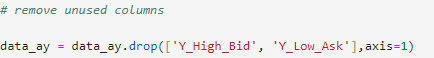

In [41]:
data_ay=data_ay.drop(['Y_High_Bid','Y_Low_Ask'],axis=1)

____________________

In [42]:
data_ay.tail(6)

,Y_High_Bid_5,Y_Low_Ask_5
354688,1.824348,1.823852
354689,NaN,NaN
354690,NaN,NaN
354691,NaN,NaN
354692,NaN,NaN
354693,NaN,NaN


,Y_High_Bid_5,Y_Low_Ask_5
354688,1.824348,1.823852
354689,NaN,NaN
354690,NaN,NaN
354691,NaN,NaN
354692,NaN,NaN
354693,NaN,NaN


#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

In [43]:
# delete the 5 last rows in data_ay (because we don't have answers for the last 5 minutes)

for i in range(5):
        data_ay.drop(data_ay.shape[0]-1, axis=0, inplace=True)


In [44]:
# delete the last 5 rows in data_ax (because we don't have answers for the last 5 minutes)

for i in range(5):
    data_ax.drop(data_ax.shape[0]-1, axis=0, inplace=True)

_______________________

In [45]:
data_ay.shape

(354689, 2)

(354689, 2)

____________________

In [46]:
data_ax.shape

(354689, 18)

(354689, 18)

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [47]:
# Create inputs Numpy

data_a = np.array(data_ax) 

with np.printoptions(precision=4):
    print("data_a:")
    print(data_a[:2,:])  
    print('\n')
    print(data_a[-2:,:]) 

print("numpy size: = ", data_a.shape)
print("type: ", data_a.dtype) 


data_a:
[[1.8286e+00 1.8296e+00 1.8285e+00 1.8295e+00 9.7176e-03 1.8297e+00
  1.8309e+00 1.8294e+00 1.8302e+00 9.0501e-03 6.2905e-01 7.0896e-04
  7.5183e-01 6.9138e-01 8.0142e-01 8.3684e-01 1.0000e+00 1.0000e+00]
 [1.8295e+00 1.8301e+00 1.8294e+00 1.8300e+00 7.1508e-03 1.8299e+00
  1.8307e+00 1.8299e+00 1.8306e+00 9.9463e-03 6.3137e-01 2.9690e-03
  8.9823e-01 8.6517e-01 8.7792e-01 8.5195e-01 0.0000e+00 0.0000e+00]]


[[1.8243e+00 1.8244e+00 1.8243e+00 1.8243e+00 2.5520e-03 1.8250e+00
  1.8251e+00 1.8249e+00 1.8250e+00 2.3750e-03 6.2938e-01 1.8801e-04
  8.5053e-01 8.5762e-01 8.7178e-01 8.5762e-01 0.0000e+00 0.0000e+00]
 [1.8244e+00 1.8245e+00 1.8243e+00 1.8243e+00 1.7923e-03 1.8250e+00
  1.8251e+00 1.8250e+00 1.8250e+00 1.3867e-03 6.2923e-01 4.3086e-04
  8.6470e-01 8.6470e-01 8.5762e-01 8.5762e-01 0.0000e+00 0.0000e+00]]
numpy size: =  (354689, 18)
type:  float32


In [76]:
# Chech the result:
# Your result from running the cell above must match the result in this cell.

data_a:
[[1.8286e+00 1.8296e+00 1.8285e+00 1.8295e+00 9.7176e-03 1.8297e+00
  1.8309e+00 1.8294e+00 1.8302e+00 9.0501e-03 6.2905e-01 7.0896e-04
  7.5183e-01 6.9138e-01 8.0142e-01 8.3684e-01 1.0000e+00 1.0000e+00]
 [1.8295e+00 1.8301e+00 1.8294e+00 1.8300e+00 7.1508e-03 1.8299e+00
  1.8307e+00 1.8299e+00 1.8306e+00 9.9463e-03 6.3137e-01 2.9690e-03
  8.9823e-01 8.6517e-01 8.7792e-01 8.5195e-01 0.0000e+00 0.0000e+00]]


[[1.8243e+00 1.8244e+00 1.8243e+00 1.8243e+00 2.5520e-03 1.8250e+00
  1.8251e+00 1.8249e+00 1.8250e+00 2.3750e-03 6.2938e-01 1.8801e-04
  8.5053e-01 8.5762e-01 8.7178e-01 8.5762e-01 0.0000e+00 0.0000e+00]
 [1.8244e+00 1.8245e+00 1.8243e+00 1.8243e+00 1.7923e-03 1.8250e+00
  1.8251e+00 1.8250e+00 1.8250e+00 1.3867e-03 6.2923e-01 4.3086e-04
  8.6470e-01 8.6470e-01 8.5762e-01 8.5762e-01 0.0000e+00 0.0000e+00]]
numpy size: =  (354689, 18)
type:  float32


#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [48]:
# Create outputs Numpy

data_y = np.array(data_ay) 

print("data_a:")
print(data_y[:3,:])  
print('\n')
print(data_y[-3:,:]) 

print("numpy size: = ", data_y.shape)
print("type: ", data_y.dtype) 

data_a:
[[1.83070397 1.829916  ]
 [1.83070397 1.83004606]
 [1.83070397 1.82989597]]


[[1.82447803 1.82425201]
 [1.82447803 1.82385194]
 [1.82434797 1.82385194]]
numpy size: =  (354689, 2)
type:  float64


In [78]:
# Chech the result:
# Your result from running the cell above must match the result in this cell.

data_a:
[[1.83070397 1.829916  ]
 [1.83070397 1.83004606]
 [1.83070397 1.82989597]]


[[1.82447803 1.82425201]
 [1.82447803 1.82385194]
 [1.82434797 1.82385194]]
numpy size: =  (354689, 2)
type:  float64


<html> <h3 style="font-style:italic; color:blue;"> Create the 3D inputs tensor, and 2D outputs matrix </h3> </html>

In [82]:
# We will analyse only part of the dataset since training the neural network with 
# an entire dataset would require massive computer power.

# n_small = 30,000 rows (minutes), which equals around 1 month.

# We need a three-dimensional data tensor: [(n_small-N ), N, 18] and
# two-dimensional array of answers [(n_small-N ), 2] with the High and Low prices DURING the next 5 minutes

# where N=50 is the number of minutes for analysis at each step; those are looking backwards 

# Therefore, we need:
# three-dimensional data tensor of sliced graphs [(n_small - N - 5), N, 18] and
# two-dimensional matrix of answers Y[(n_small - N - 5), 2] with the High and Low prices shifted sequentially to 5 rows up.

________________________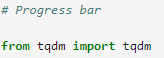

In [49]:
from tqdm import tqdm

___________________________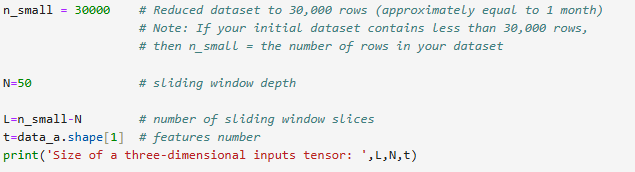

In [50]:
n_small = 30000 


N=50 

L=n_small-N # number of sliding window slices

t=data_a.shape[1] 

print('Size of a three-dimensional inputs tensor: ',L,N,t)

Size of a three-dimensional inputs tensor:  29950 50 18


Size of a three-dimensional inputs tensor:  29950 50 18


#### Now just press 'CTRL' and 'ENTER' keys on the next 3 cells.

In [51]:
# create imputs zeros 3D tensors with 'float32'

data_b = np.zeros( (L, N, t), dtype= 'float32' ) 

In [52]:
# create a two-dimensional zeros vector of answers - normalised the High_Bid and Low_Ask prices DURING next 5 minutes

Y = np.zeros((L, 2), dtype= 'float32') # We will predict two prices - normalised High_Bid and normalised Low_Ask

In [1]:
# fill the imputs 3D tansor (data_b) 
# and the array of answers Y 

#print('L = n - N = ', n-N, L)
print('L = n_small - N - 5 = ', n_small-N-5, L)
#for k in tqdm(range(L-1)):
for k in tqdm(range(L)):
    data_b[k, :, :] = data_a[k:k+N, :]   
                                          
    Y[k,0] = data_y[k+N-1,0]   # normalised Y_High_Bid - max 5 minutes future price
    Y[k,1] = data_y[k+N-1,1]   # normalised Y_Low_Ask -  min 5 minutes future price

print(k) # index value (for control)
    
print('data_b:', '\n', data_b)
print("Numpy size:        ", data_b.shape, '\n')

print( Y[:5,:])
print( Y[-10:,:])
print(      "Numpy size:         ", Y.shape)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'data_a' is not defined

In [92]:
# Chech the result:
# Your result from running the cell above must match the result in this cell.

L = n_small - N - 5 =  29945 29950


100%|██████████| 29950/29950 [00:00<00:00, 347057.11it/s]

29949
data_b: 
 [[[1.828604   1.829628   1.828544   ... 0.8368359  1.         1.        ]
  [1.829504   1.830104   1.829398   ... 0.851948   0.         0.        ]
  [1.830098   1.830604   1.829998   ... 0.85572606 0.         0.        ]
  ...
  [1.828188   1.828198   1.828058   ... 0.9048406  0.         0.        ]
  [1.828178   1.828178   1.827978   ... 0.90247935 0.         0.        ]
  [1.827998   1.828058   1.827968   ... 0.90247935 0.         0.        ]]

 [[1.829504   1.830104   1.829398   ... 0.851948   0.         0.        ]
  [1.830098   1.830604   1.829998   ... 0.85572606 0.         0.        ]
  [1.830534   1.830704   1.830504   ... 0.91239667 0.         0.        ]
  ...
  [1.828178   1.828178   1.827978   ... 0.90247935 0.         0.        ]
  [1.827998   1.828058   1.827968   ... 0.90247935 0.         0.        ]
  [1.828048   1.828158   1.827898   ... 0.89681226 0.         0.        ]]

 [[1.830098   1.830604   1.829998   ... 0.85572606 0.         0.        ]
  [1.8

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [54]:
# Control of the correctness of filling the array Y 
# (should show MAX of the normalised prices High_Bid and Low_Ask - during 5 next minutes(step) ahead)


import random

pp = random.randint(50, L) # (any number before 29950) - just to look at the middle of data_b
print('random int = ', pp)

print('data_b:', '\t\t','Y:')
print('Y_High_Bid ','\t\t','Y_High_Bid')

for i in range(15):
    print(data_b[pp+i,N-1,1], '\t\t', Y[pp+i,0])

random int =  23470
data_b: 		 Y:
Y_High_Bid  		 Y_High_Bid
1.847038 		 1.847178
1.847078 		 1.847178
1.847078 		 1.847178
1.847108 		 1.847178
1.847178 		 1.847068
1.847058 		 1.847068
1.846968 		 1.847068
1.847034 		 1.847178
1.846994 		 1.847268
1.847068 		 1.847298
1.846998 		 1.847298
1.847018 		 1.847298
1.847178 		 1.847298
1.847268 		 1.847298
1.847298 		 1.847264


random int =  23368
data_b: 		 Y:
Y_High_Bid  		 Y_High_Bid
1.847478 		 1.847648
1.847568 		 1.847648
1.847648 		 1.847568
1.847568 		 1.847558
1.847558 		 1.847508
1.847468 		 1.847508
1.847508 		 1.847508
1.847508 		 1.847558
1.847418 		 1.847808
1.847488 		 1.848198
1.847494 		 1.848248
1.847358 		 1.848248
1.847558 		 1.848248
1.847808 		 1.848588
1.848198 		 1.848588


In [96]:
# Each rows of Y above must have maximum of prices of 5 minute ahead
# you can run several times the cell above 

_________________________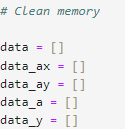

In [55]:
data=[]
data_ax=[]
data_ay=[]
data_a=[]
data_y=[]


<html> <h2 style="font-style:italic; olor:blue;"> Train Test Split </h2> </html>

- 90% for training and validation
- 10% for testing

In [56]:
from sklearn.model_selection import train_test_split

<html> <h3 style="font-style:bold; color:red;"> !!! Use parameters: shuffle = False, stratify = None

Otherwise, the whole time series will be mixed up!
</h3> </html>

________________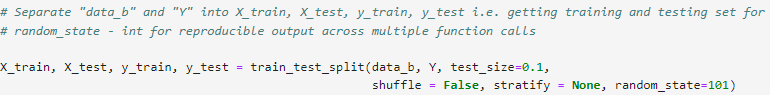

In [57]:
# Separate "data_b"™ and "Y" into X_train, X_ test, y train, y test i.e. getting training and testing set for
# random_state - int for reproducible output across multiple function calls

X_train, X_test, y_train, y_test = train_test_split(data_b, Y, test_size=0.1,

shuffle = False, stratify = None, random_state=101)

In [58]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(26955, 50, 18)
(26955, 2)
(2995, 50, 18)
(2995, 2)


(26955, 50, 18)
(26955, 2)
(2995, 50, 18)
(2995, 2)


<html> <h2 style="color:blue;"> Training </h2> </html>

<html> <h3 style="color:blue;"> LSTM </h3> </html>

___________________________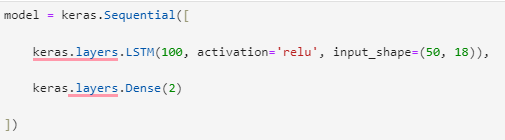

In [59]:
model=keras.Sequential([

    keras.layers.LSTM(100, activation='relu',input_shape=(50,18)),
    keras.layers.Dense(2)

])

C:\Users\vital\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


_________________________

In [61]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               47600     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 47802 (186.73 KB)
Trainable params: 47802 (186.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,802 (186.73 KB)

 Trainable params: 47,802 (186.73 KB)

 Non-trainable params: 0 (0.00 B)

None


<html> <h3 style="font-style:italic; color:blue;"> Callbacks </h3> </html>

__________________________

In [62]:
model.compile(optimizer="adam",loss="mse",metrics=["mae"])

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [63]:
# Early Stopping parameters

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model_LSTM_GOLD.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

<html> <h4 style="font-style:bold; color:red;"> If you are using your own laptop without a GPU (Graphics processing unit), 

please change the following parameter in the next cell  </h4> </html>
<html> <h3 style="font-style:bold; color:blue;">
epochs=10
</h3> </html>


__________________________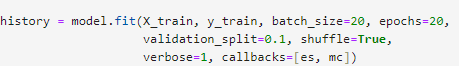

In [65]:
history = model.fit(
    X_train, y_train,
    batch_size=20,
    epochs=20,
    validation_split=0.1,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc]
)


Epoch 1/20
1213/1213 [==============================] - ETA: 0s - loss: 0.0176 - mae: 0.0203
Epoch 1: val_loss improved from inf to 0.00002, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 25s 19ms/step - loss: 0.0176 - mae: 0.0203 - val_loss: 1.9804e-05 - val_mae: 0.0035
Epoch 2/20
1211/1213 [============================>.] - ETA: 0s - loss: 1.0337e-05 - mae: 0.0025
Epoch 2: val_loss improved from 0.00002 to 0.00001, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 24s 20ms/step - loss: 1.0339e-05 - mae: 0.0025 - val_loss: 9.1139e-06 - val_mae: 0.0021
Epoch 3/20
1212/1213 [============================>.] - ETA: 0s - loss: 9.4184e-06 - mae: 0.0024
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 29s 24ms/step - loss: 9.4157e-06 - mae: 0.0024 - val_loss: 6.3713e-06 - val_mae: 0.0019
Epoch 4/20
1211/1213 [===============

Epoch 1/20
1211/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0529 - mae: 0.0523
Epoch 1: val_loss improved from inf to 0.00002, saving model to best_model_LSTM_GOLD.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0527 - mae: 0.0522 - val_loss: 2.0870e-05 - val_mae: 0.0033
Epoch 2/20
1210/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9688e-05 - mae: 0.0035
Epoch 2: val_loss improved from 0.00002 to 0.00002, saving model to best_model_LSTM_GOLD.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 1.9688e-05 - mae: 0.0035 - val_loss: 1.8964e-05 - val_mae: 0.0032
Epoch 3/20
1212/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0251e-05 - mae: 0.0035
Epoch 3: val_loss did not improve from 0.00002
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 2.0252e-05 - mae: 0.0035 - val_loss: 1.9401e-05 - val_mae: 0.0038
Epoch 4/20
1210/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3436e-05 - mae: 0.0038
Epoch 4: val_loss improved from 0.00002 to 0.00002, saving model t

_______________________________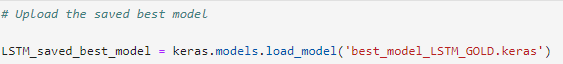

In [66]:
LSTM_saved_best_model = keras.models.load_model('best_model_LSTM_GOLD.keras')

<html> <h3 style="font-style:italic; color:blue;"> Test </h3> </html>

#### Now just press 'CTRL' and 'ENTER' keys on the next 4 cells.

In [67]:
# Evaluate the quality of network training on test data, which the network has NOT seen.

scores = LSTM_saved_best_model.evaluate(X_test, y_test, verbose=1)

94/94 [==============================] - 2s 14ms/step - loss: 4.6397e-06 - mae: 0.0017


In [68]:
scores

[4.639693997887662e-06, 0.0017051848117262125]

In [69]:
print("Mean squared error (mse): %.9f " % (scores[0]))

Mean squared error (mse): 0.000004640 


In [70]:
print("Mean absolute error (mae): %.9f " % (scores[1]))

Mean absolute error (mae): 0.001705185 


<html> <h2 style="font-style:italic; color:blue;"> Visualisation </h2> </html>

<html> <h3 style="font-style:italic; color:blue;"> MSE training graphs </h3> </html>

___________________________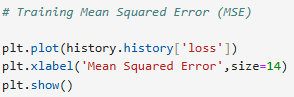

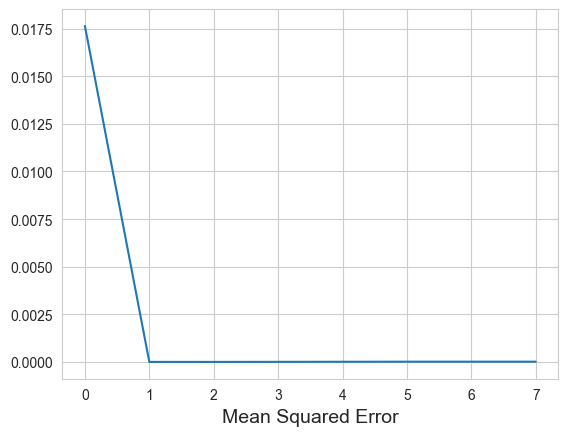

In [71]:
plt.plot(history.history['loss'])
plt.xlabel('Mean Squared Error',size=14)
plt.show()

Text(0.5, 0, 'Mean Squared Error')

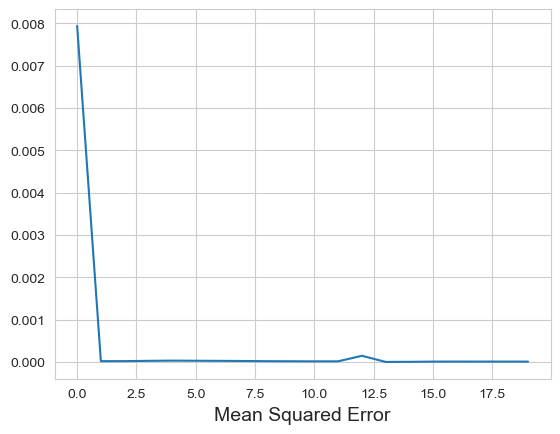

#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

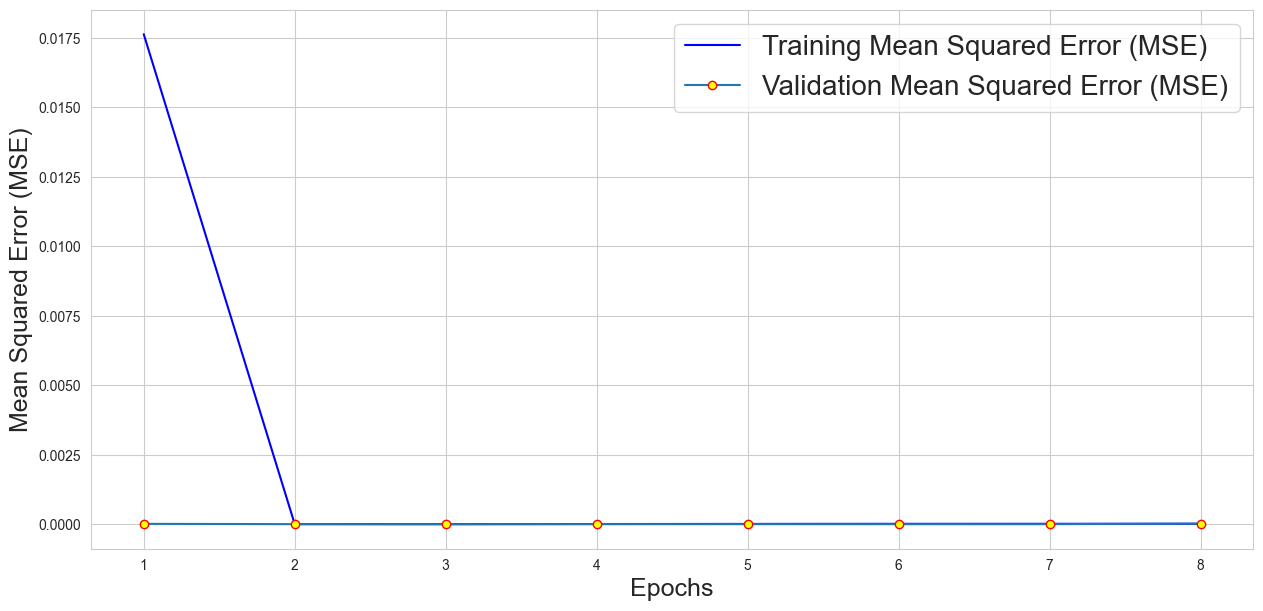

In [72]:
# More detailed MSE graph

history_dict = history.history

mse_values = history_dict['loss']
val_mse_values = history_dict['val_loss']

epochs = range(1, len(mse_values) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, mse_values, 'b', label='Training Mean Squared Error (MSE)')
plt.plot(epochs, val_mse_values, marker='o', markeredgecolor='red', markerfacecolor='yellow', label='Validation Mean Squared Error (MSE)')
plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Squared Error (MSE)', size=18)
plt.legend()
plt.show()

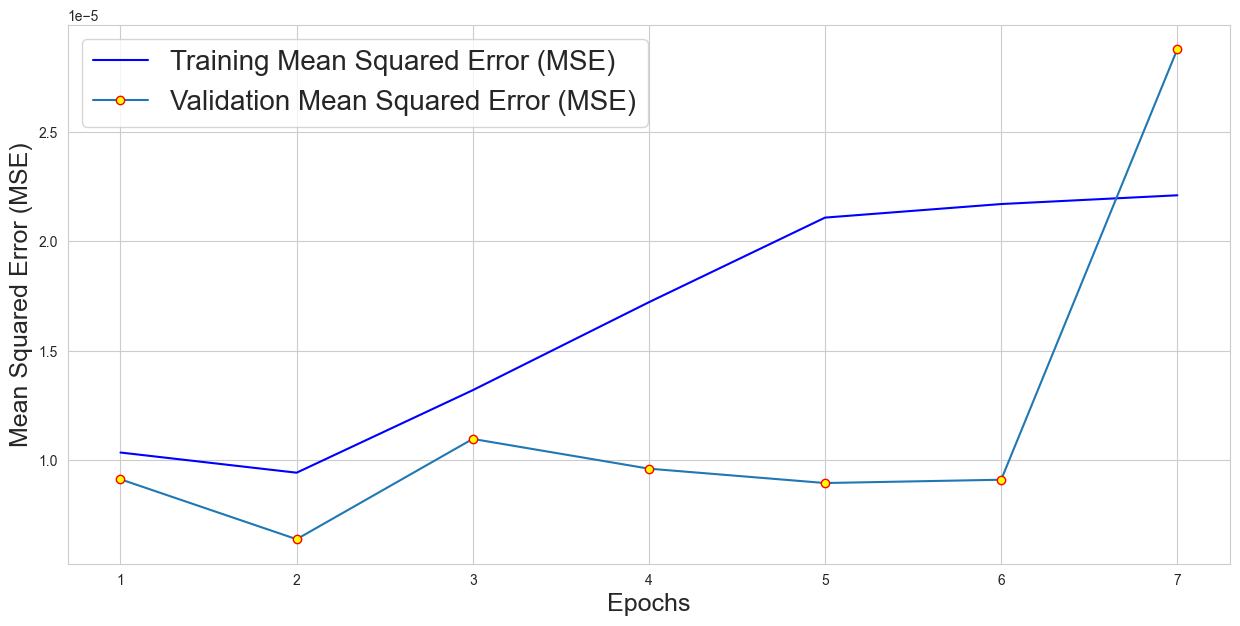

In [73]:
# deleted the 1st epoch
# to examine in detail the results of the remaining epochs

history_dict = history.history

mse_values = history_dict['loss'][1:]
val_mse_values = history_dict['val_loss'][1:]

epochs = range(1, len(mse_values) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, mse_values, 'b', label='Training Mean Squared Error (MSE)')
plt.plot(epochs, val_mse_values, marker='o', markeredgecolor='red', markerfacecolor='yellow', label='Validation Mean Squared Error (MSE)')
plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Squared Error (MSE)', size=18)
plt.legend()
plt.show()

<html> <h3 style="font-style:italic; color:blue;"> MAE training graphs </h3> </html>

__________________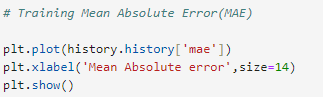

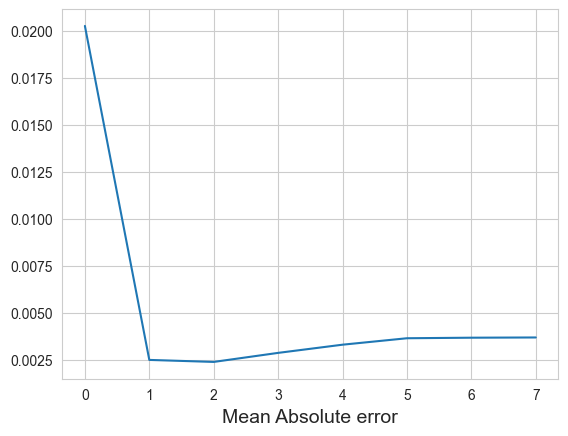

In [78]:
plt.plot(history.history['mae'])
plt.xlabel('Mean Absolute error',size=14)
plt.show()

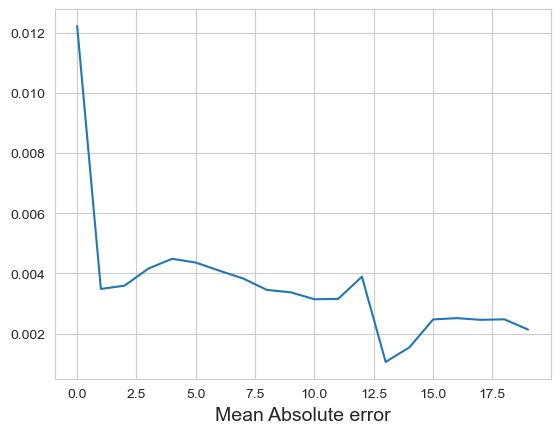

____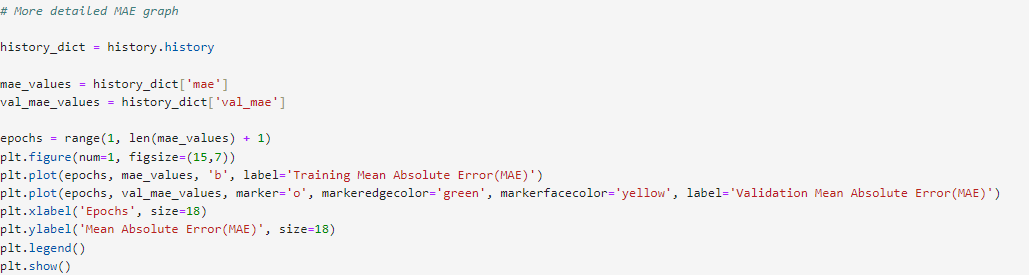

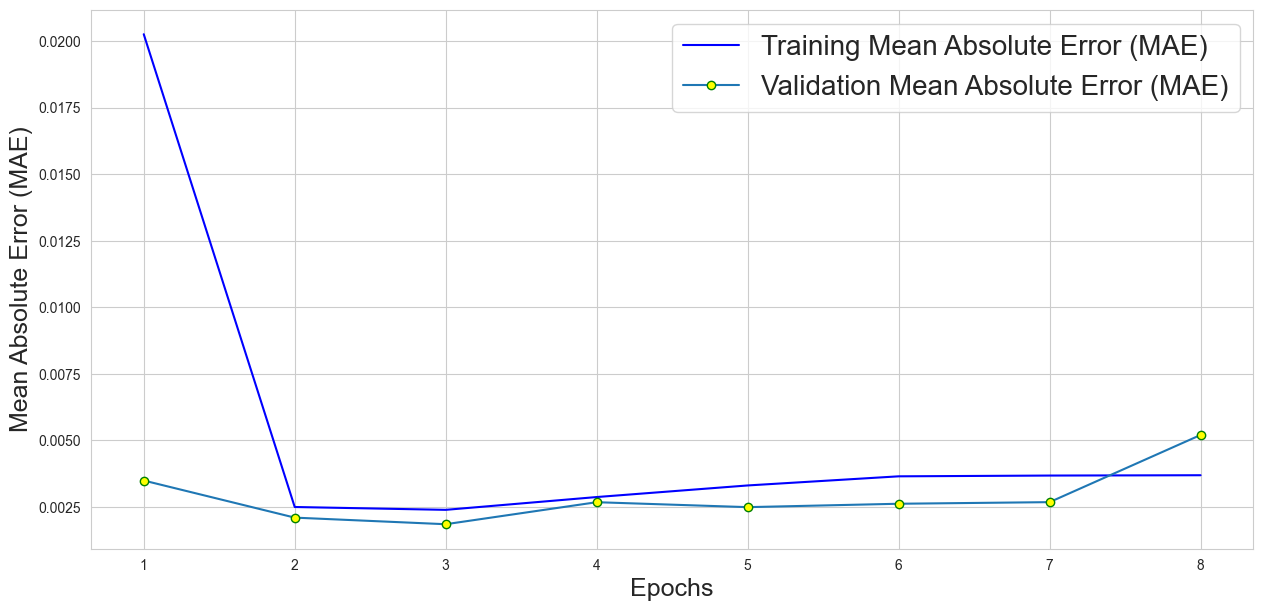

In [79]:
history_dict = history.history
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']

epochs = range(1, len(mae_values) + 1)

plt.figure(num=1, figsize=(15, 7))
plt.plot(epochs, mae_values, 'b', label='Training Mean Absolute Error (MAE)')
plt.plot(epochs, val_mae_values, marker='o', markeredgecolor='green',
         markerfacecolor='yellow', label='Validation Mean Absolute Error (MAE)')

plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Absolute Error (MAE)', size=18)
plt.legend()
plt.show()


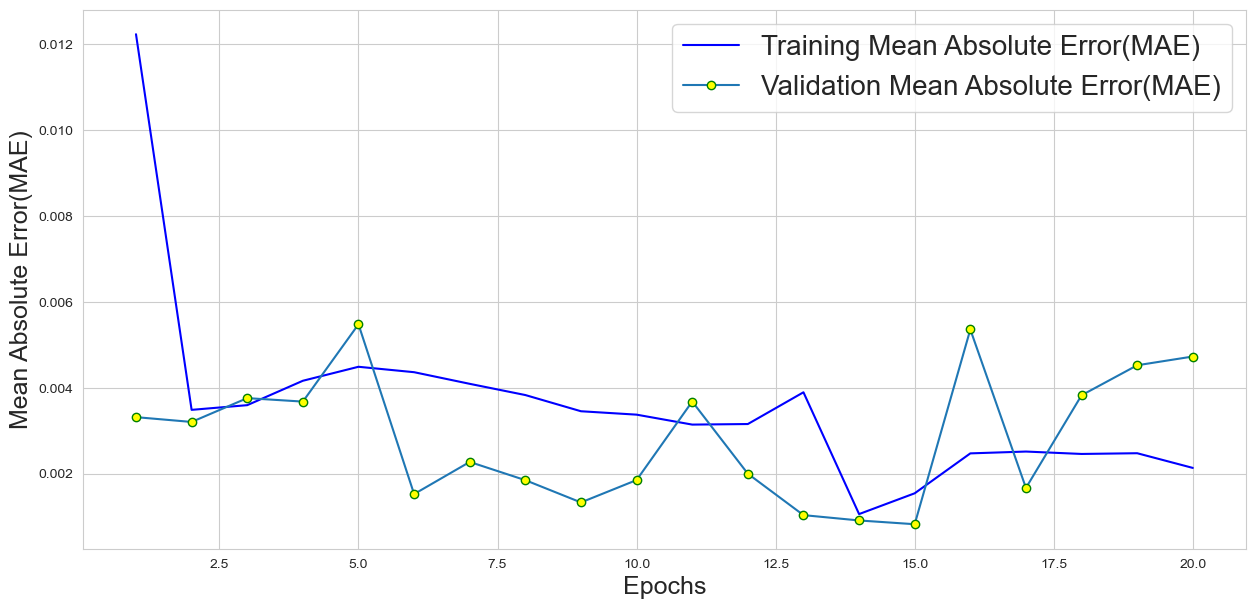

<html> <h3 style="font-style:italic; color:blue;"> Prediction 5 minute ahead </h3> </html>

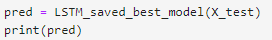

In [80]:
pred= LSTM_saved_best_model(X_test)
print(pred)

tf.Tensor(
[[1.7843769 1.7823699]
 [1.7838739 1.7825341]
 [1.7835859 1.7817125]
 ...
 [1.8030292 1.8012142]
 [1.8024656 1.800615 ]
 [1.8033143 1.8000597]], shape=(2995, 2), dtype=float32)


tf.Tensor(
[[1.7847013 1.7831059]
 [1.7841758 1.7829924]
 [1.7838504 1.7827185]
 ...
 [1.800886  1.8009316]
 [1.8011881 1.8008903]
 [1.8007932 1.800265 ]], shape=(2995, 2), dtype=float32)


<html> <h3 style="font-style:italic; color:blue;"> Price chart </h3> </html>

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

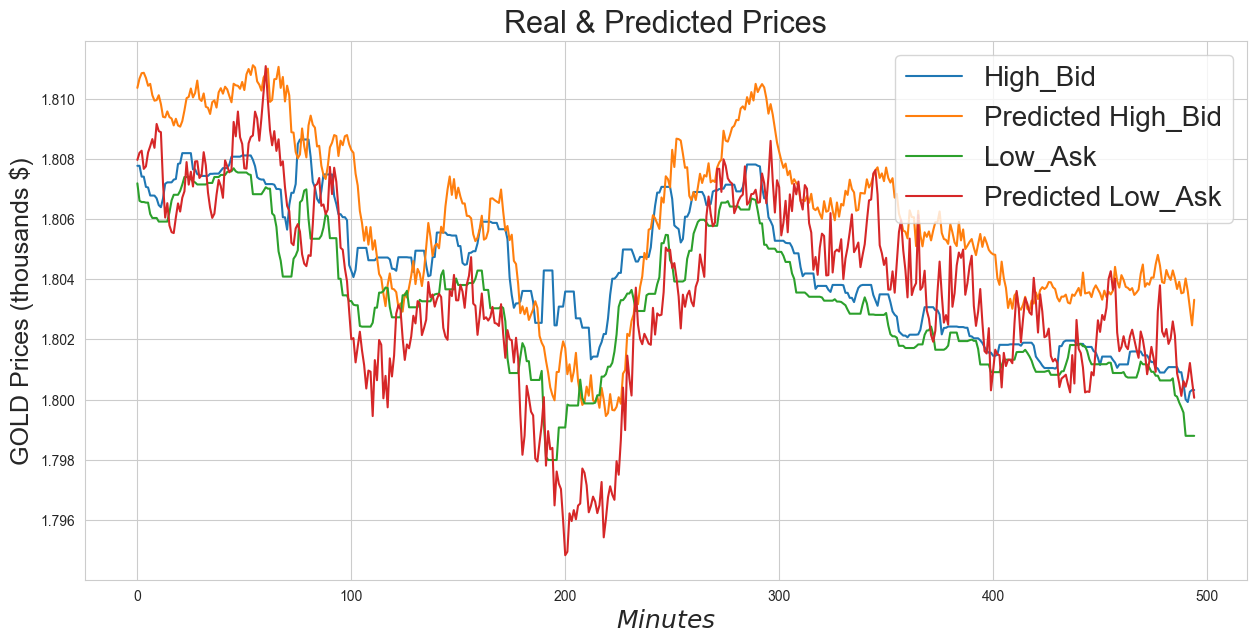

In [81]:
N1=2500  # The first minute for the chart  
LL = 500  # Duration (in minutes) for the chart
N2=N1+LL  # the last minute for the chart

plt.ion()
fig = plt.figure(figsize=(15,7))  

ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test[N1:N2,0], label='High_Bid')
line2, = ax1.plot(pred[N1:N2,0], label='Predicted High_Bid')
line3, = ax1.plot(y_test[N1:N2,1], label='Low_Ask')
line4, = ax1.plot(pred[N1:N2,1], label='Predicted Low_Ask')

plt.title('Real & Predicted Prices', size=22)
plt.ylabel('GOLD Prices (thousands $)', size=18)
plt.xlabel('$Minutes$', size=18)
plt.legend(loc='upper right') 

plt.show()


<html> <h3 style="font-style:italic; color:blue;"> Error Chart </h3> </html>

__________________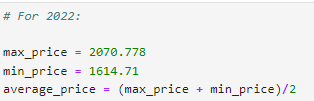

In [83]:
max_price=2020.778
min_price=1614.71
average_price=(max_price + min_price)/2

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

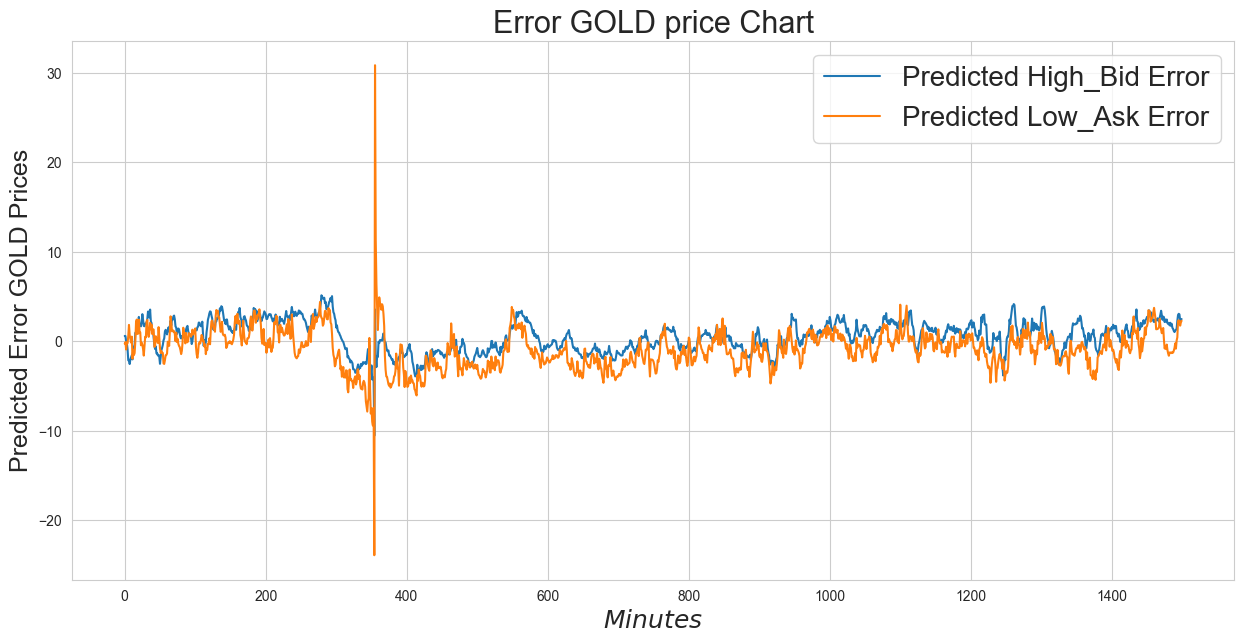

In [84]:
N1=0  # The first minute for the chart  
LL = 1500  # leigt (in minutes) for the chart
N2=N1+LL  # the last minute for the chart
# N2 should be < len(pred)

plt.ion()
fig = plt.figure(figsize=(15,7))  

ax1 = fig.add_subplot(111)

# in $ (absolute price)
a = (pred[N1:N2,0] - y_test[N1:N2,0]) *1000
b = (pred[N1:N2,1] - y_test[N1:N2,1]) *1000

# in %
#a = (pred[N1:N2,0] - y_test[N1:N2,0]) *1000/ average_price *100
#b = (pred[N1:N2,1] - y_test[N1:N2,1]) *1000/ average_price *100


line1, = ax1.plot(a, label='Predicted High_Bid Error')
line2, = ax1.plot(b, label='Predicted Low_Ask Error')

plt.title('Error GOLD price Chart', size=22)
plt.ylabel('Predicted Error GOLD Prices', size=18)
plt.xlabel('$Minutes$', size=18)
plt.legend(loc='upper right') 

plt.show()

# Lab Logbook Requirement:

<html> <h3 style="font-style:italic; color:blue;">
   
1) Modify the practical session LSTM model parameter from 100 to be calculated using the formula: 

   ZY + 10
   , where your SID is: XXXXXZY

   (For example, if your SID is 2287167, then LSTM model parameter = 67+10=77)
3) Change the epochs to 10.
4) Change the patience to 3
5) Leave other parameters the same as in the practical session.
6) Compile the model.
6) Train your LSTM with the same datasets and demonstrate the received test MSE & MAE.
Compare your test MSE & MAE with the MSE & MAE of the LSTM in the practical session.
7) Please only add to your Lab Logbook the print-screens of:
- your LSTM architecture using model.summary(),
- training process,
- the resulting test MSE & MAE and
- MAE detailed graph.


    
</h3> </html>

<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK, AND UPLOAD THE LAB LOGBOOK REQUIREMENTS AS A SCREENSHOT OF YOUR CODE AND RESULT(S) ON YOUR GITHUB.
</h3> </html>

In [85]:

# SID: 2428622  →  ZY = 22  →  LSTM units = ZY + 10 = 32

from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = keras.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=(50, 18)),
    keras.layers.Dense(2)
])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                6528      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 6594 (25.76 KB)
Trainable params: 6594 (25.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [86]:
# --- Compile the LSTM Model ---
# SID: 2428622
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [87]:
# --- EarlyStopping and ModelCheckpoint Callbacks ---
# SID: 2428622
# Patience changed from 5 → 3 as per logbook requirement

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
mc = ModelCheckpoint('best_model_LSTM_LOGBOOK.keras',
                     monitor='val_loss', mode='min',
                     verbose=1, save_best_only=True)


In [88]:
# --- Train the Model ---
# SID: 2428622
# Epochs changed from 20 → 10 as per logbook requirement

history = model.fit(
    X_train, y_train,
    batch_size=20,
    epochs=10,
    validation_split=0.1,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc]
)


Epoch 1/10
1209/1213 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0113
Epoch 1: val_loss improved from inf to 0.00002, saving model to best_model_LSTM_LOGBOOK.keras
1213/1213 [==============================] - 16s 12ms/step - loss: 0.0047 - mae: 0.0112 - val_loss: 1.7022e-05 - val_mae: 0.0033
Epoch 2/10
1212/1213 [============================>.] - ETA: 0s - loss: 8.9721e-06 - mae: 0.0023
Epoch 2: val_loss improved from 0.00002 to 0.00001, saving model to best_model_LSTM_LOGBOOK.keras
1213/1213 [==============================] - 15s 12ms/step - loss: 8.9712e-06 - mae: 0.0023 - val_loss: 1.0511e-05 - val_mae: 0.0025
Epoch 3/10
1211/1213 [============================>.] - ETA: 0s - loss: 7.4672e-06 - mae: 0.0021
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to best_model_LSTM_LOGBOOK.keras
1213/1213 [==============================] - 15s 12ms/step - loss: 7.4631e-06 - mae: 0.0021 - val_loss: 1.0413e-05 - val_mae: 0.0027
Epoch 4/10
1209/1213 [======

In [89]:
# --- the resulting test MSE & MAE---
# SID: 2428622
scores = model.evaluate(X_test, y_test, verbose=1)

print(f"Mean squared error (MSE): {scores[0]:.9f}")
print(f"Mean absolute error (MAE): {scores[1]:.9f}")


94/94 [==============================] - 0s 3ms/step - loss: 3.1294e-05 - mae: 0.0054
Mean squared error (MSE): 0.000031294
Mean absolute error (MAE): 0.005434982


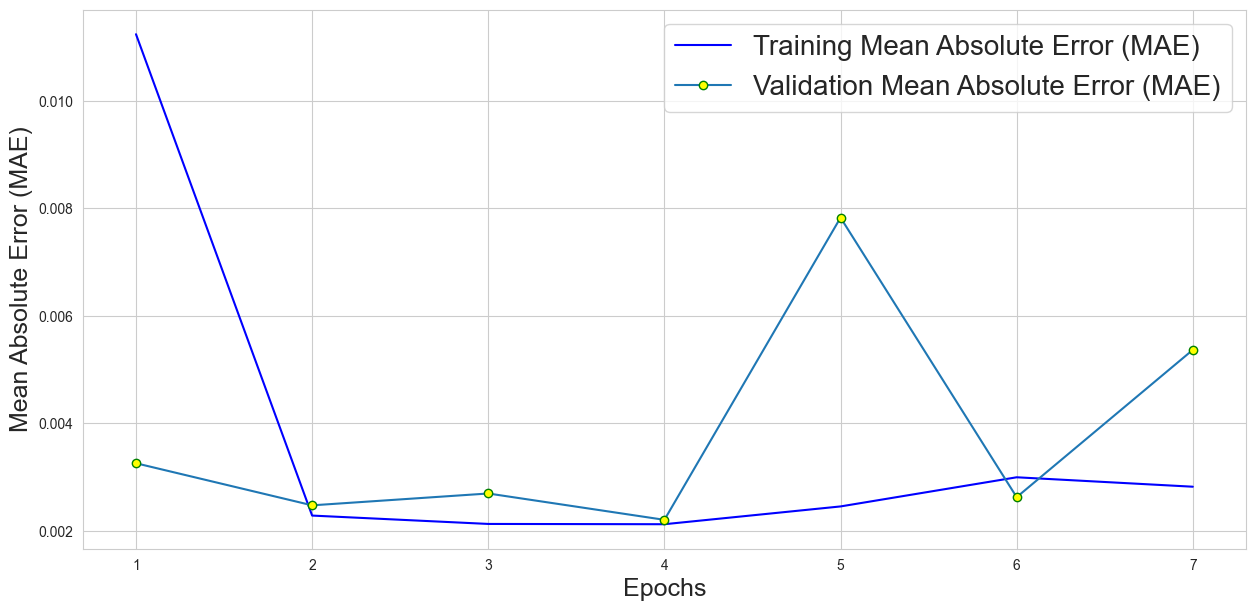

In [91]:
history_dict = history.history
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']

epochs = range(1, len(mae_values) + 1)

plt.figure(num=1, figsize=(15, 7))
plt.plot(epochs, mae_values, 'b', label='Training Mean Absolute Error (MAE)')
plt.plot(epochs, val_mae_values, marker='o', markeredgecolor='green',
         markerfacecolor='yellow', label='Validation Mean Absolute Error (MAE)')

plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Absolute Error (MAE)', size=18)
plt.legend()
plt.show()
